In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

from my_imports import acf_plot
from my_imports import sarimax_plot, sarimax_eval
from File_creation import gap_less

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

/Users/mauriekathan/anaconda3/envs/dsi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (10,12,13,16,17,18,22,24,28,30,32,37,43,49,52,54,58,60,68,70,74,77,79,80,82,84,86,88,90,92,100,101,102,103,104,106,108,119,121,124,125,126,127,133,142,144,146,148,150,152,158,160,162,164,166,168,170,176,179,181,185,187,188,194) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/mauriekathan/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Creating Dissolved Oxygen Dataset

In [2]:
#created aggregated dataframe with which averages the data from all of the sites.
agg_data = gap_less.groupby(gap_less.index).mean()

In [3]:
#creating dissolved only dataframe
do_data = agg_data[['dissolved_oxygen', 'water_temperature']]

In [4]:
do_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233 entries, 1996-06-08 to 2018-12-10
Data columns (total 2 columns):
dissolved_oxygen     233 non-null float64
water_temperature    233 non-null float64
dtypes: float64(2)
memory usage: 5.5 KB


In [5]:
do_data.describe()

,dissolved_oxygen,water_temperature
count,233.000000,233.000000
mean,10.831713,12.722035
std,1.522554,2.496850
min,4.440000,5.414286
25%,9.978000,10.900000
50%,10.664286,12.871429
75%,11.452000,14.470000
max,17.062000,18.698462


In [6]:
do_data.head()

,dissolved_oxygen,water_temperature
date,,
1996-06-08,10.97,12.40
1996-07-14,11.03,14.51
1996-08-10,10.48,13.39
1996-09-13,10.14,15.97
1996-10-14,10.33,13.60


In [7]:
do_data.tail()

,dissolved_oxygen,water_temperature
date,,
2018-08-09,7.764286,14.928571
2018-09-17,10.962857,13.242857
2018-10-08,11.777143,14.057143
2018-11-05,10.664286,11.042857
2018-12-10,12.300000,8.900000


## Rolling Mean

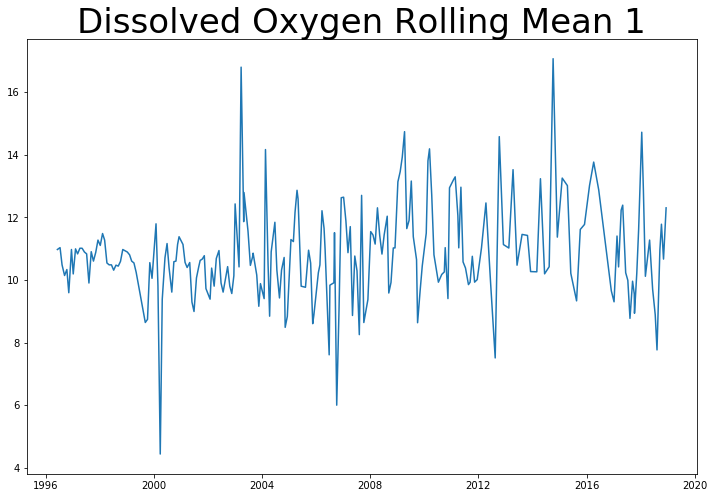

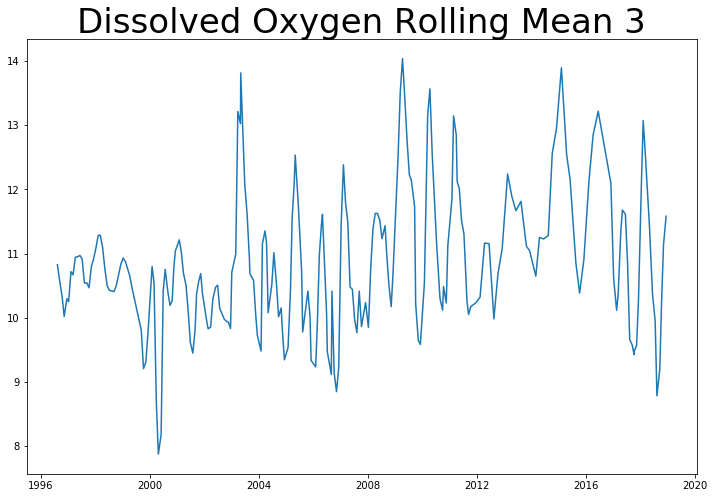

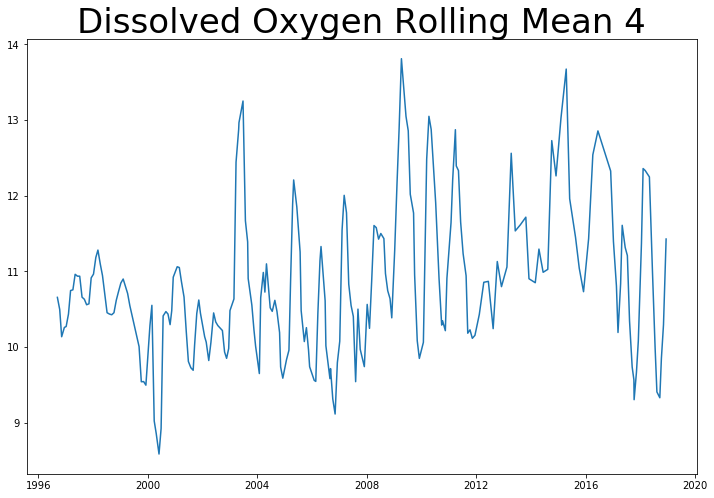

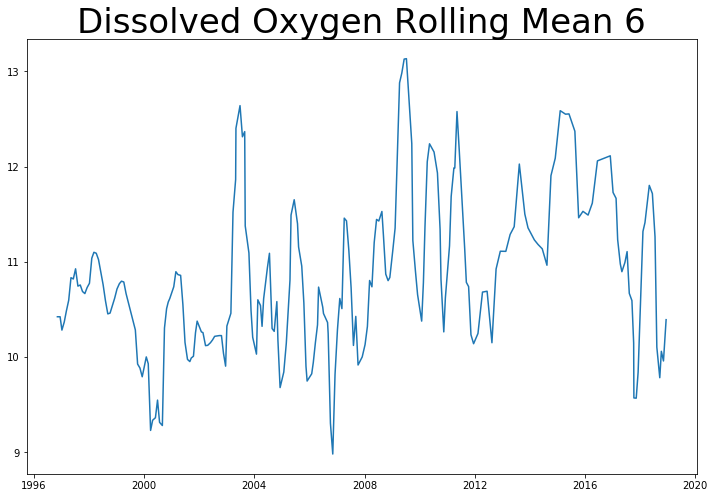

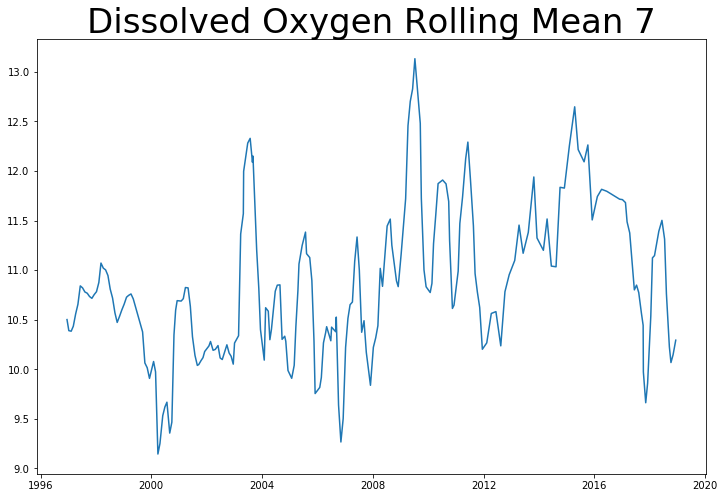

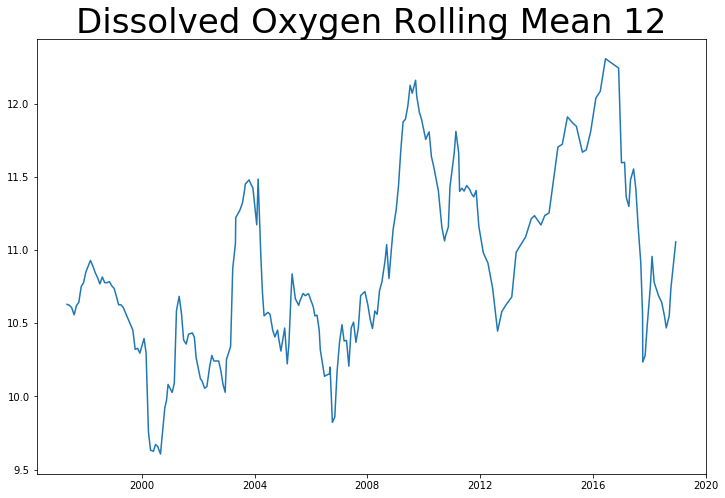

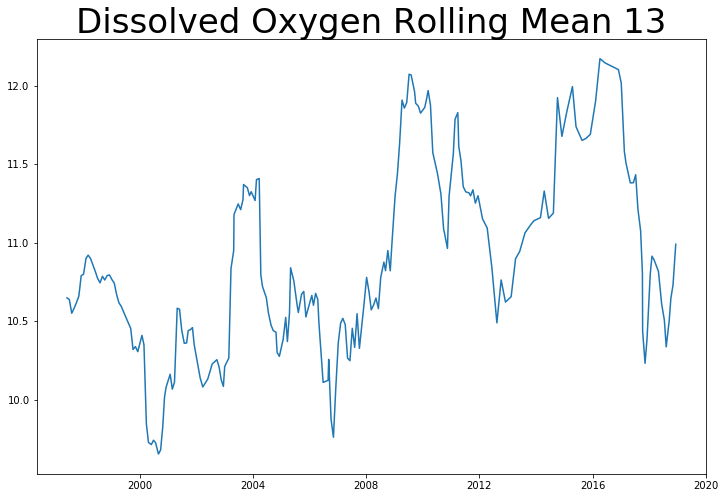

In [8]:
#creating a for loop to review rolling means
for num in [1,3,4,6,7,12,13]:
    fig = plt.figure(figsize=(12, 8))
    #plotting rolling mean with steps in for loop
    plt.plot(do_data['dissolved_oxygen'].rolling(num).mean())
    #setting title
    plt.title(f'Dissolved Oxygen Rolling Mean {num}', fontsize = 34)
    plt.show()

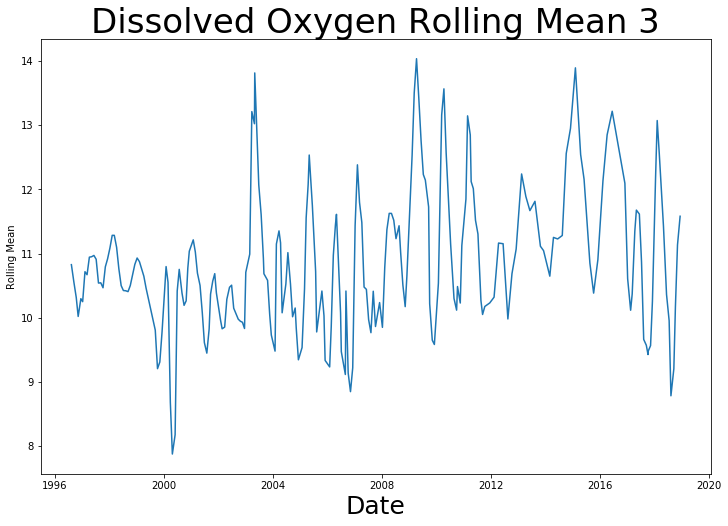

In [9]:
#creating plot for presentation

fig = plt.figure(figsize=(12, 8))
plt.plot(do_data['dissolved_oxygen'].rolling(3).mean())
plt.title(f'Dissolved Oxygen Rolling Mean 3', fontsize = 34)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Rolling Mean')
plt.show()
fig.savefig('./Images/Rolling_mean_3.png',bbox_inches='tight')

## Dickey Fuller

In [10]:
#analyzing stationarity of the data
print("Test Stat:", adfuller(do_data['dissolved_oxygen'])[0])
print("P-Value:", adfuller(do_data['dissolved_oxygen'])[1])

Test Stat: -10.966970204751973
P-Value: 8.057773505476658e-20


## ACF and PACF

0.310007222438017


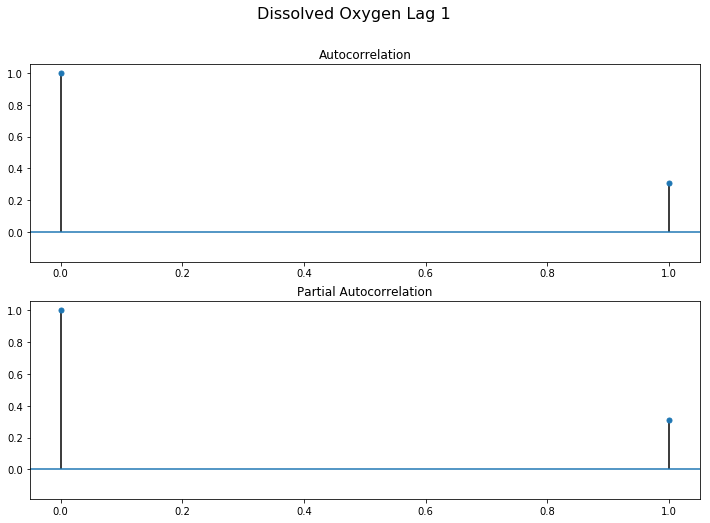

0.10515954911437742


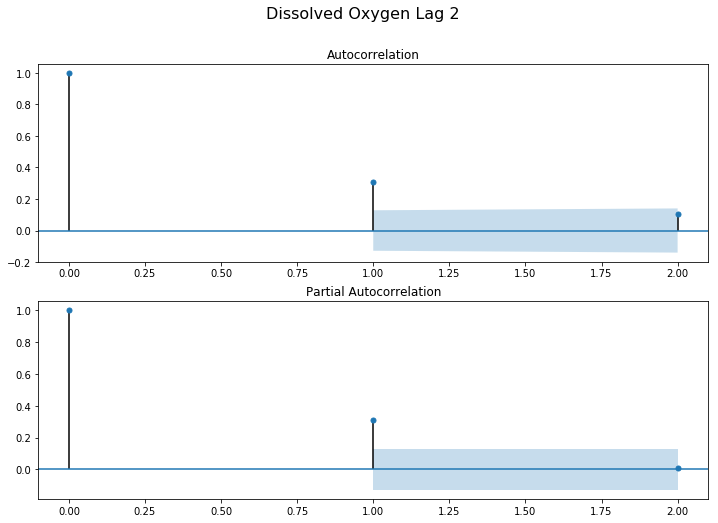

0.08355684568766548


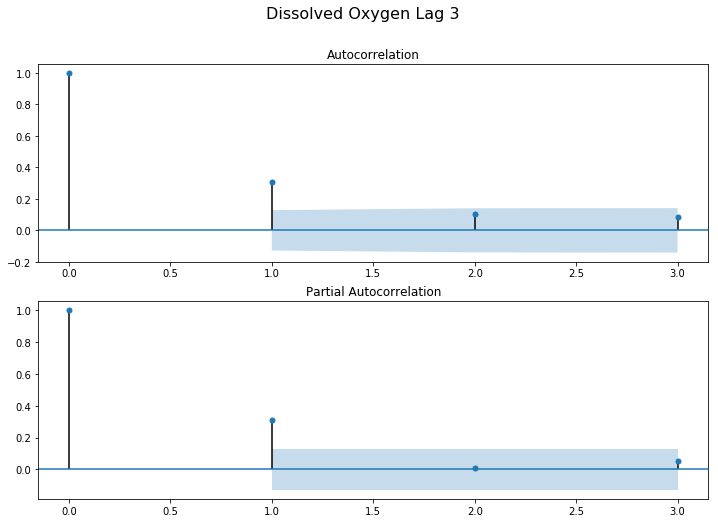

-0.0925408373419476


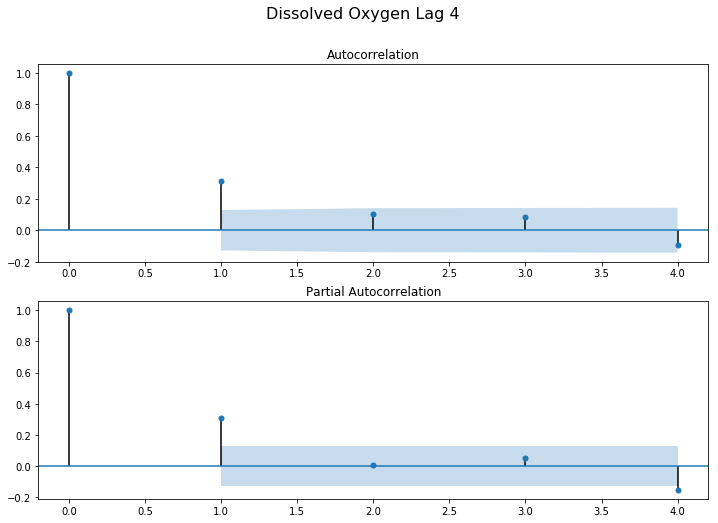

-0.04415211334280031


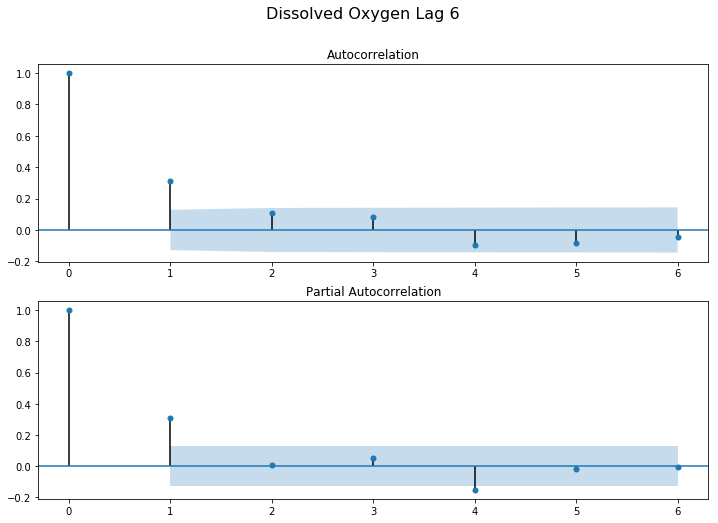

-0.0029921750241159463


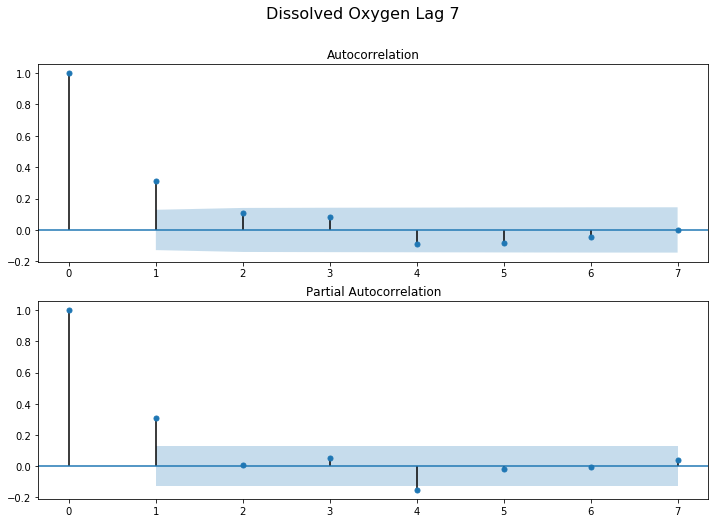

0.2427625944281364


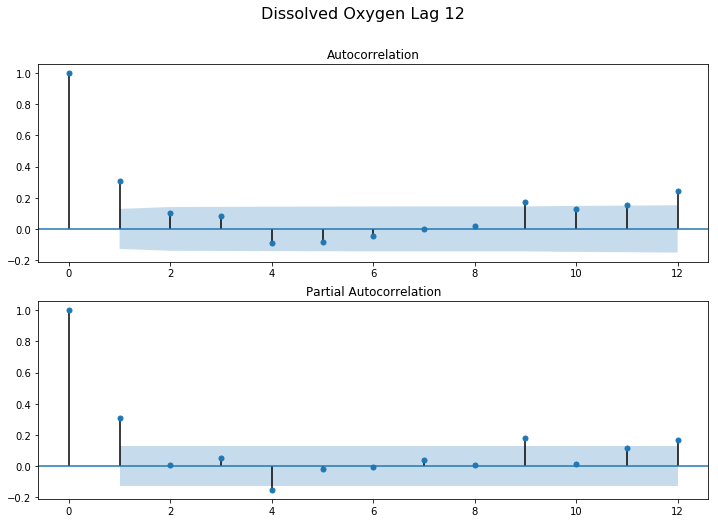

0.02606211440617367


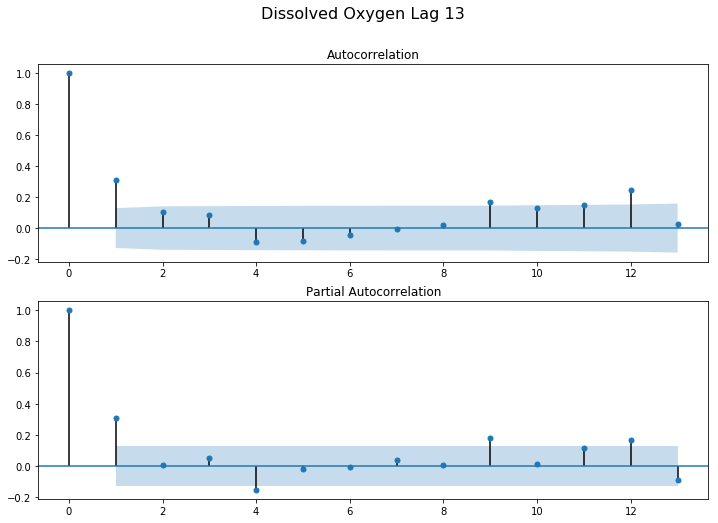

In [11]:
#reviewing acf plots for different logs
for num in [1,2,3,4,6,7,12,13]:
    acf_plot(do_data['dissolved_oxygen'],num,'Dissolved Oxygen')

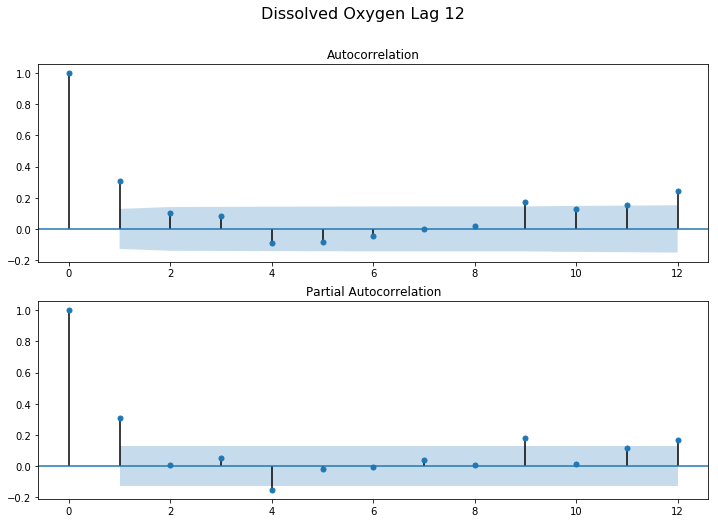

In [12]:
#creating plot for presentations
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)

fig = plot_acf(do_data['dissolved_oxygen'], lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(do_data['dissolved_oxygen'], lags=12, ax=ax2)
fig.suptitle(f'Dissolved Oxygen Lag 12', fontsize=16)
plt.show()
fig.savefig('./Images/acf_pacf_12.png',bbox_inches='tight')

## Train Test

In [13]:
#identifying shape of training set
do_data.shape[0] * .8

186.4

In [14]:
#Slitting data into training and testing shapes
train = do_data.iloc[0:186]
test = do_data.iloc[186:]

In [15]:
test.shape

(47, 2)

In [16]:
train.shape

(186, 2)

In [17]:
do_data.shape

(233, 2)

## Modeling

In [18]:
#finding baseline
train.dissolved_oxygen.mean()

10.739188723462918

In [19]:
# Checking different param models and reviewing metrics with d of 0
parameters0 = []
for num in [3,4,8,11]:
    for intg in [0,1,2]:
        for i in [2,3,4]:
            for n in [3,4,5]:
                    params = sarimax_eval(train, test, train['dissolved_oxygen'], test['dissolved_oxygen'],
                                          start=186, end=232, p=num, d=0, q=intg, P=i, D=0, Q=n, S=12)
                    parameters0.append(params)

In [20]:
#Making model evaluation dataframe and then review top preforming models
parameters0_df = pd.DataFrame(parameters0)
parameters0_df.sort_values(ascending = True, by = 'AIC').head(10)

,AIC,D,P,Q,S,d,mae,p,q
26,466.514743,0,4,5,12,0,1.319124,3,2
17,467.403062,0,4,5,12,0,1.289210,3,1
8,467.968364,0,4,5,12,0,1.284016,3,0
53,468.392006,0,4,5,12,0,1.312630,4,2
44,469.380625,0,4,5,12,0,1.292723,4,1
35,469.956111,0,4,5,12,0,1.284857,4,0
2,475.375037,0,2,5,12,0,1.305345,3,0
20,475.474861,0,2,5,12,0,1.329279,3,2
23,475.507399,0,3,5,12,0,1.386929,3,2
14,475.607691,0,3,5,12,0,1.386301,3,1


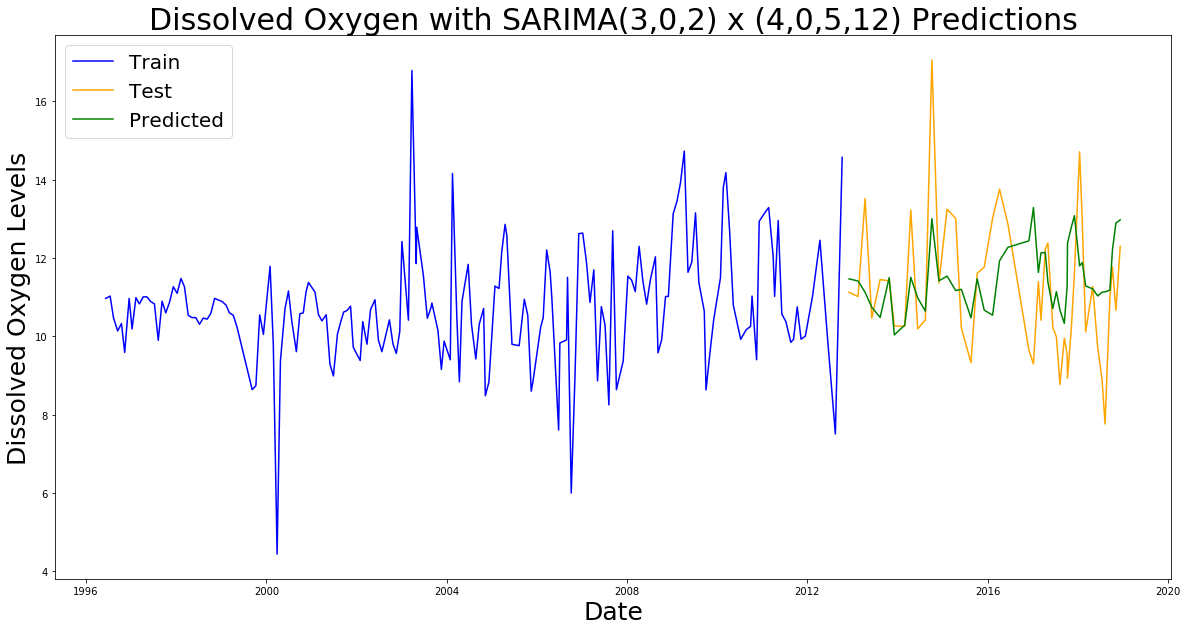

In [43]:
#creating plot of best preforming model for presentation
sarima = SARIMAX(endog = train['dissolved_oxygen'],
                     order = (3,0,2),              # (p, d, q)
                     seasonal_order=(4,0,5,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)# (P, D, Q, S))

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.

preds = model.predict(start=186,end=232)


# Plot data.
fig=plt.figure(figsize=(20,10))
plt.plot(train.index, train['dissolved_oxygen'], color = 'blue')
plt.plot(test.index, test['dissolved_oxygen'], color = 'orange')
plt.plot(test.index, preds, color = 'green')
plt.title(label = f'Dissolved Oxygen with SARIMA(3,0,2) x (4,0,5,12) Predictions', fontsize=30)
plt.legend(labels = ('Train', 'Test', 'Predicted'), fontsize=20, loc = 'upper left')
plt.xlabel('Date', fontsize=25)
plt.ylabel('Dissolved Oxygen Levels', fontsize=25)
plt.show();
fig.savefig('./Images/SARIMAX302.png',bbox_inches='tight')

In [44]:
# reviewing the results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                   dissolved_oxygen   No. Observations:                  186
Model:             SARIMAX(3, 0, 2)x(4, 0, 5, 12)   Log Likelihood                -218.257
Date:                            Wed, 06 Mar 2019   AIC                            466.515
Time:                                    13:50:53   BIC                            508.698
Sample:                                         0   HQIC                           483.649
                                            - 186                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4611      1.917      0.241      0.810      -3.296       4.218
ar.L2          0.3396      2.075      0.164      0.870      -3.728       4.407
ar.L3         -0.1307      0.397     -0.329      0.742      -0.908       0.647
ma.L1         -0.2457      1.946     -0.126      0.900      -4.060       3.569
ma.L2         -0.3769      1.757     -0.215      0.830      -3.821       3.067
ar.S.L12       0.6028      0.231      2.615      0.009       0.151       1.055
ar.S.L24       0.0793      0.208      0.382      0.703      -0.328       0.486
ar.S.L36      -0.1168      0.214     -0.545      0.585      -0.537       0.303
ar.S.L48       0.4524      0.182      2.492      0.013       0.097       0.808
ma.S.L12      -0.2753     14.640     -0.019      0.985     -28.969      28.418
ma.S.L24      -0.3673     17.030     -0.022      0.983     -33.745      33.011
ma.S.L36       0.1467     12.605      0.012      0.991     -24.559      24.853
ma.S.L48      -0.6172     10.113     -0.061      0.951     -20.438      19.203
ma.S.L60       0.1366      1.849      0.074      0.941      -3.487       3.760
sigma2         1.5394     20.384      0.076      0.940     -38.413      41.492
===================================================================================
Ljung-Box (Q):                       24.93   Jarque-Bera (JB):                25.66
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.05
Prob(H) (two-sided):                  0.64   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

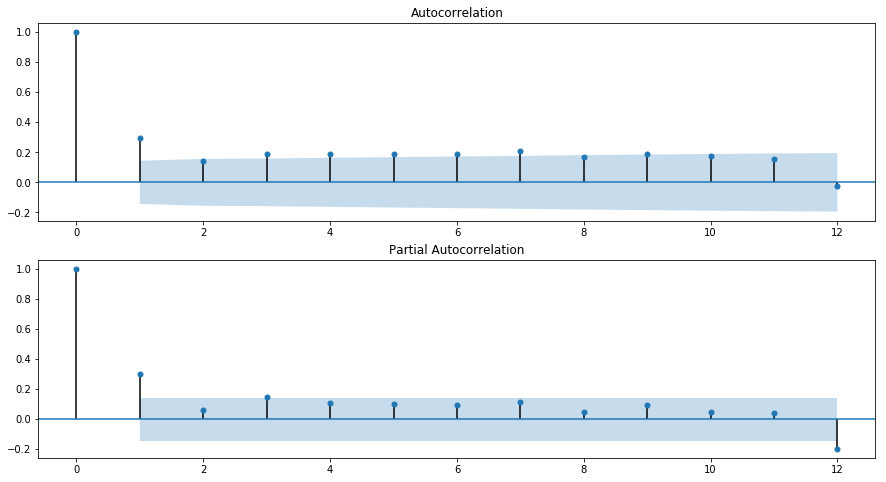

In [45]:
res = model.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = plot_acf(res, lags=12, ax=ax[0])
fig = plot_pacf(res, lags=12, ax=ax[1])
plt.show()

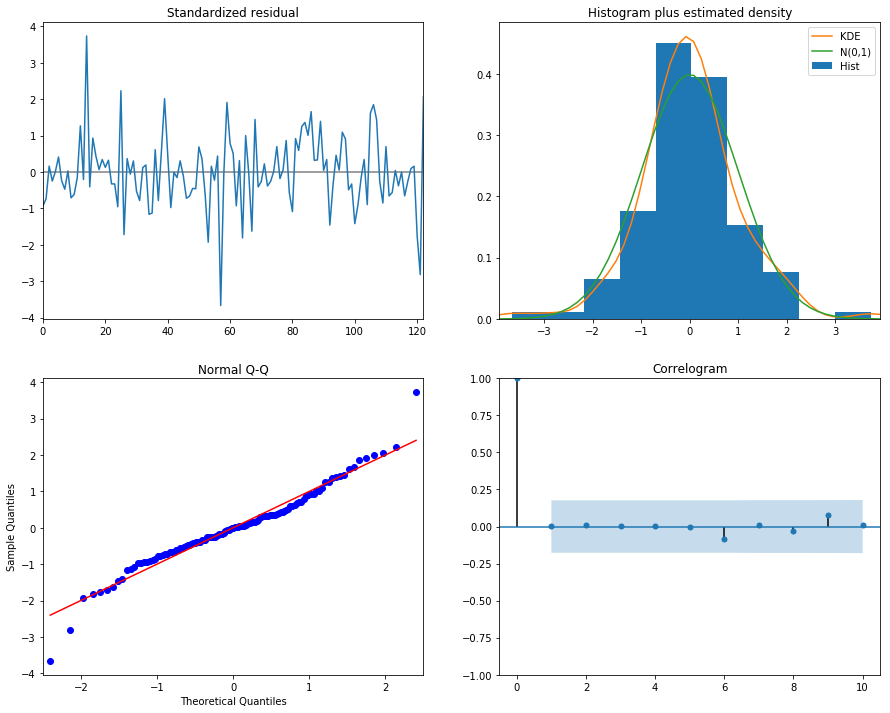

In [46]:
model.plot_diagnostics(figsize=(15, 12));

In [61]:
pred = model.get_prediction(start=234, end = 246, dynamic=False)
pred_ci = pred.conf_int()

In [62]:
pred.summary_frame()

dissolved_oxygen,mean,mean_se,mean_ci_lower,mean_ci_upper
234,11.554036,1.412845,8.784910,14.323161
235,11.652757,1.412926,8.883473,14.422040
236,11.434735,1.412901,8.665500,14.203971
237,11.105064,1.412868,8.335894,13.874235
238,10.997677,1.412860,8.228522,13.766833
239,11.336283,1.412858,8.567133,14.105434
240,10.792287,1.412857,8.023138,13.561436
241,10.979213,1.412771,8.210233,13.748193
242,12.097283,1.412650,9.328540,14.866026
243,12.021462,1.412264,9.253476,14.789448


In [ ]:
#saving data used for analysis to csv
do_data.to_csv('./Data/DO_data.csv')